Naive stock price prediction program using LSTM recurrent neural networks, licensed under the Apache License, Version 2.0<br>
http://www.apache.org/licenses/LICENSE-2.0

# General libraries

In [19]:
# Importing the numpy library (for arrays operations)
# Importing the pandas library (for data analysis)
# Importing the matplotlib.pyplot interface (for MATLAB-like plots)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset preparation
We retrieve the data of Netflix stock prices from Jan 04, 2010 to May 10, 2022 ("NFLX Historical Data.csv") from investing.com:<br>
https://www.investing.com/equities/netflix,-inc.-historical-data

In [3]:
# Storing the data in DataFrame "df", sorted by date in ascending order

df = pd.read_csv('NFLX Historical Data.csv')
df = df[::-1]
df

,Date,Price,Open,High,Low,Vol.,Change %
3110,"Jan 04, 2010",7.64,7.93,7.96,7.57,17.24M,-2.92%
3109,"Jan 05, 2010",7.36,7.65,7.66,7.26,23.75M,-3.66%
3108,"Jan 06, 2010",7.62,7.36,7.67,7.20,23.29M,3.53%
3107,"Jan 07, 2010",7.49,7.73,7.76,7.46,9.96M,-1.71%
3106,"Jan 08, 2010",7.61,7.50,7.74,7.47,8.18M,1.60%
...,...,...,...,...,...,...,...
4,"May 04, 2022",204.01,197.65,204.38,191.01,12.22M,2.07%
3,"May 05, 2022",188.32,200.45,200.71,186.00,13.97M,-7.69%
2,"May 06, 2022",180.97,186.75,187.21,175.81,17.19M,-3.90%
1,"May 09, 2022",173.10,177.65,183.20,172.30,14.03M,-4.35%


In [4]:
# Storing "Open" values of stock prices in a numpy array "arr", and reshaping it into a vertical array

arr = df['Open'].values
arr = arr.reshape(-1, 1)
arr.shape

(3111, 1)

In [5]:
# Splitting the data into a training set stored in array "train_arr" (first 90% of the rows of "arr")
# And a test set stored in array "test_arr" (last 10% of the rows of "arr")
# Storing in list "dates" the dates corresponding to "test_arr"

train_arr = arr[:int(arr.shape[0]*0.9)]
test_arr = arr[int(arr.shape[0]*0.9):]
dates = df['Date'].tolist()[int(arr.shape[0]*0.9):]

train_arr.shape, test_arr.shape, len(dates)

((2799, 1), (312, 1), 312)

We import the estimator "MinMaxScaler" from the sklearn.preprocessing module to rescale the data to a given range, typically the interval [0,1].<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

We rescale with MinMaxScaler the training data and, in order to avoid any look-ahead bias, we use the scaling parameters of the training data to rescale the test data too.<br>
https://www.investopedia.com/terms/l/lookaheadbias.asp

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_arr = scaler.fit_transform(train_arr)
test_arr = scaler.transform(test_arr)

We define a function "create_sequences" which creates two numpy arrays "sequences" and "labels" given an array "arr" and a number of time steps "n". The 1D numpy array labels contains all the last values of arr, starting from the n-th value. The 2D numpy array sequences contains all the sequences of n consecutive values of arr.

In [7]:
def create_sequences(arr, n):
    sequences, labels = [], []
    for i in range(n, arr.shape[0]):
        sequences.append(arr[i-n: i, 0])
        labels.append(arr[i, 0])
    return np.array(sequences), np.array(labels)

In [9]:
# Setting a number of time steps n
# Using the function create_sequences to create the training set and test set for the model
# Storing in "dates" the list of dates corresponding to test_labels

n = 30
train_seqs, train_labels = create_sequences(train_arr, n)
test_seqs, test_labels = create_sequences(test_arr, n)
dates = dates[n:]

train_seqs.shape, train_labels.shape, test_seqs.shape, test_labels.shape, len(dates)

((2769, 30), (2769,), (282, 30), (282,), 282)

In [10]:
# Reshaping train_seqs and test_seqs into the 3D array needed for the LSTM input layer of the model
# The 3D array includes: number of rows, number of time steps and number of features (here 1 for "Open" values)

train_seqs = np.reshape(train_seqs, (train_seqs.shape[0], train_seqs.shape[1], 1))
test_seqs = np.reshape(test_seqs, (test_seqs.shape[0], test_seqs.shape[1], 1))

train_seqs.shape, test_seqs.shape

((2769, 30, 1), (282, 30, 1))

# RNN model

In [11]:
# Importing the "Sequential" class from the keras.models API (to group a linear stack of layers into a model)
# Importing the "load_model" function from the keras.models API (to load a model saved via model.save())
# Importing the "LSTM" class from the keras.layers API (to load the long short-term memory layer to be used)
# Importing the "Dense" class from the keras.layers API (to load the regular densely-connected NN layer to be used)
# Importing the "Dropout" class from the keras.layers API (to apply dropout to the input)

# See https://keras.io/api/models/ and https://keras.io/api/layers/

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

We define a RNN model which takes as input the stock prices of n consecutive days and gives as output a prediction of stock price at day n+1:

- we set the class of the model as Sequential.
- we add an LSTM layer with units_ℓ output units (with option "return_sequences=True" to set the output as a 3D array)
- we add a Dropout layer with frequency rate r_ℓ
- we add an LSTM layer with units_ℓ output units (with option "return_sequences=True" to set the output as a 3D array)
- we add a Dropout layer with frequency rate r_ℓ
- we add an LSTM layer with units_ℓ output units
- we add a Dropout layer with frequency rate r_d
- we add a Dense layer with 1 output unit (the dimension of 1 stock price prediction)

In [12]:
units_ℓ = 128
r_ℓ = 0.2
r_d = 0.4

model = Sequential()
model.add(LSTM(units=units_ℓ, return_sequences=True, input_shape=(n, 1)))
model.add(Dropout(r_ℓ))
model.add(LSTM(units=units_ℓ, return_sequences=True))
model.add(Dropout(r_ℓ))
model.add(LSTM(units=units_ℓ))
model.add(Dropout(r_d))
model.add(Dense(units=1))

In [11]:
# Summary of the model, see https://keras.io/api/models/model/#summary-method

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

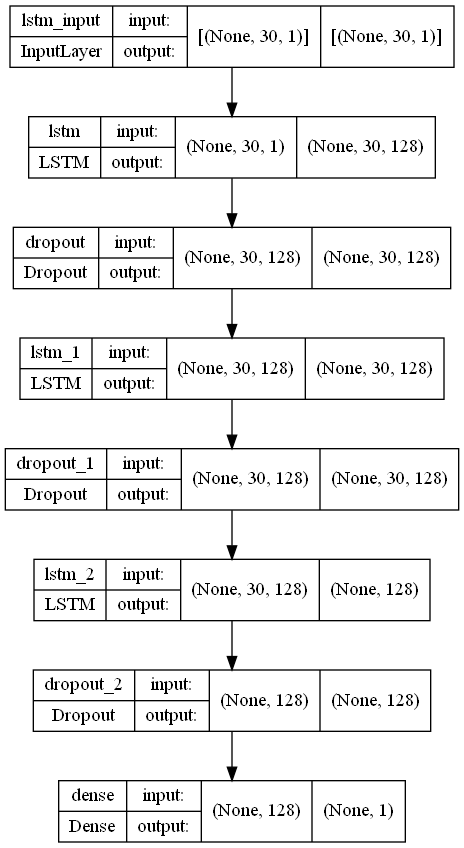

In [13]:
# Importing the "plot_model" function from keras.utils.vis_utils module (to plot a schema of the model)
# The "None" value stands for the (not yet defined) value of the batch size
# See https://keras.io/api/utils/model_plotting_utils/

from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True)

We configure (compile) the model for training with:<br>
- mean square error (mse) between labels and predictions as quantity to minimise during training process
- root mean absolute error between labels and predictions as metric to display during training process
- "adam" as optimizer to use during training process (a combination of gradient descent with momentum and RMSP)<br>
https://keras.io/api/optimizers/adam/

In [14]:
model.compile(loss='mse', optimizer='adam', metrics='RootMeanSquaredError')

We train the model with a given batch size and number of epochs. An epoch is a pass of the neural network over the entire training set and the batch size is the number of samples that are passed to the network at once (the default batch size in Keras is 32).<br>
https://keras.io/api/models/model_training_apis/#fit-method

For each epoch, we thus have
$$
\hbox{number of training steps} = \frac{\hbox{length of training set}}{\hbox{batch size}}\;\!.
$$

In [14]:
# Training the model and saving the model's attributes in a HDF5 file
# See https://en.wikipedia.org/wiki/Hierarchical_Data_Format

batch_size = 2
epochs = 15
model.fit(train_seqs, train_labels, batch_size=batch_size, epochs=epochs)
model.save('model_parameters.h5')

Epoch 1/15
1385/1385 [==============================] - 135s 89ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694
Epoch 2/15
1385/1385 [==============================] - 131s 94ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482
Epoch 3/15
1385/1385 [==============================] - 143s 103ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486
Epoch 4/15
1385/1385 [==============================] - 145s 105ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478
Epoch 5/15
1385/1385 [==============================] - 106s 77ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436
Epoch 6/15
1385/1385 [==============================] - 113s 82ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407
Epoch 7/15
1385/1385 [==============================] - 149s 108ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435
Epoch 8/15
1385/1385 [==============================] - 263s 190ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393
Epoch 9/15
1385/1385 [==============

# 1-day ahead predictions
In this section, we use the fitted model to generate 1-day ahead stock price predictions.

In [15]:
# Storing in numpy array "predicted" the one-day-ahead stock prices predicted by the model
# Storing in numpy array "real" the real stock prices contained in "test_labels"
# Putting back both arrays to the original scale and format

model = load_model('model_parameters.h5')

predicted = model.predict(test_seqs)
predicted = scaler.inverse_transform(predicted)
real = scaler.inverse_transform(test_labels.reshape(-1, 1))

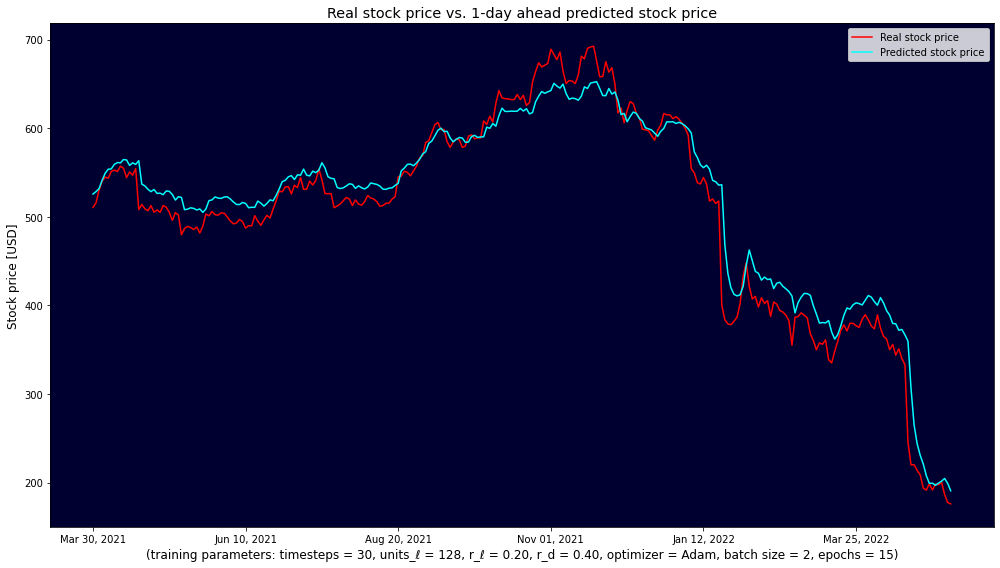

In [22]:
# Graph plot of real stock prices vs. one-day ahead predicted stock prices

_, p = plt.subplots(figsize=(14,8))

p.plot(dates, real, color='r', label='Real stock price')
p.plot(dates, predicted, color='cyan', label='Predicted stock price')

# Parameters, title and legend of the plot

p.set_title('Real stock price vs. 1-day ahead predicted stock price', size='x-large')
p.set_ylabel('Stock price [USD]', size='large')
p.set_xlabel('(training parameters: timesteps = %d, units_ℓ = %d, r_ℓ = %.2f, r_d = %.2f, optimizer = Adam, batch size = %d, epochs = %d)'
             % (n, units_ℓ, r_ℓ, r_d, batch_size, epochs), size='large')
plt.xticks(np.arange(0, len(dates)+1, 50))
p.set_facecolor('#000030')
p.legend()

plt.tight_layout()

# N-days ahead predictions
In this section, we use the fitted model to generate N-days ahead stock price predictions.

In [20]:
# Setting the number "N" of days ahead predictions and the day "start_day" where to start the prediction
# Defining a list "N_predictions" containing the future N stock price predictions
# Setting as "data" the initial real stock price at start_day 

N = 10
start_day = 200
N_predictions = []
data = test_seqs[start_day: start_day+1]

# For-loop for the prediction of N consecutive stock prices after start_day

for i in range(N):
    prediction = model.predict(data)
    data = np.append(data, prediction)[1:]
    data = data.reshape(1,-1, 1)
    N_predictions.append(prediction[0][0])

# Putting the list of predictions "N_predictions" to the original scale and format

N_predictions = np.array(N_predictions).reshape(-1, 1)
N_predictions = scaler.inverse_transform(N_predictions)

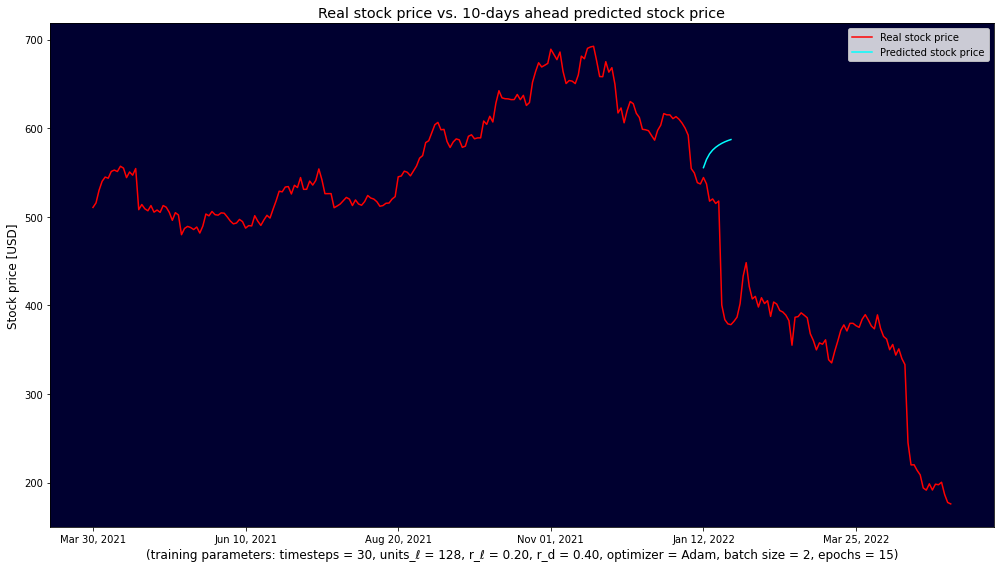

In [23]:
# Graph plot of real stock prices vs. N-days ahead predicted stock prices

_, p2 = plt.subplots(figsize=(14,8))

p2.plot(dates, real, color='r', label='Real stock price')
p2.plot(dates[start_day: start_day+N], N_predictions, color='cyan', label='Predicted stock price')

# Parameters, title and legend of the plot

p2.set_title(('Real stock price vs. %d-days ahead predicted stock price' % N), size='x-large')
p2.set_ylabel('Stock price [USD]', size='large')
p2.set_xlabel('(training parameters: timesteps = %d, units_ℓ = %d, r_ℓ = %.2f, r_d = %.2f, optimizer = Adam, batch size = %d, epochs = %d)'
             % (n, units_ℓ, r_ℓ, r_d, batch_size, epochs), size='large')
plt.xticks(np.arange(0, len(dates)+1, 50))
p2.set_facecolor('#000030')
p2.legend()

plt.tight_layout()

# Conclusion
Looking at the 1-day ahead predictions, the LSTM model seem to be accurate. But a more careful inspection shows that it is not the case. When one uses the model to generate N-days ahead predictions, one obtains unsatisfactory results (not able to indicate the right trend - raising or falling - of the stock price).

Two hints of explanations are the following:
- First, the parameters from the training data (maximum and minimum values) used to rescale the test data are usually not suitable for the test data. Indeed, since stock prices are not bounded from above, the value of stock prices in the future often surpass the values of stock price observed in the past. This can lead to scales incongruities, as one can for instance observe in the first graph.
- Second, and more importantly, the behaviour of stock prices is so complex that one cannot expect to accurately predict it using simple, deterministic models. The LSTM model that we use here is no exception to this rule. One has to develop more complex models (including randomness, sliding data windows, daily stock returns, etc.) to get more decent predictions.